In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
# pip install miceforest

In [5]:
# pip install missingpy

In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
# from functools import reduce

from IPython.display import display

#Preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#Imputation
# import miceforest as mf
# import random
# import sklearn.neighbors._base 
# import sys
# sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
# from missingpy import MissForest
# from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer

#Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import datasets
import xgboost as xgb

#Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, r2_score, precision_recall_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import plot_importance

In [60]:
#Function for creating our confusion matrices
def conf_matrix(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix', fontsize=14)
  plt.ylabel('True label', fontsize=14)
  plt.xlabel('Predicted label', fontsize=14)
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45,fontsize=14)
  plt.yticks(tick_marks, classNames,fontsize=14)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
        plt.text(j, i, str(s[i][j]) + " = " + str(cm[i][j]), fontsize=20, horizontalalignment="center")  # Adjust text font size and alignment
 
  plt.show()

In [7]:
#Read in the data
df = pd.read_csv("AR_cleaned_ISB_aging_new_merge_fi_wgcna.csv")

In [7]:
#Look at all the columns we have
df.columns

Index(['public_client_id', 'sex', 'age', 'merge_fi', 'MElightcyan',
       'MEgreenyellow', 'MEpurple', 'MEblue', 'MEbrown', 'MEgreen',
       'MEmidnightblue', 'MEcyan', 'MEtan', 'MEyellow', 'MEblack', 'MEmagenta',
       'MEred', 'MEsalmon', 'MEpink', 'MEturquoise', 'MEgrey',
       'MEturquoise_prots', 'MEblue_prots', 'MEbrown_prots', 'MEgrey_prots',
       'A/G RATIO', 'ALAT (SGPT)', 'ALBUMIN', 'ALKALINE PHOSPHATASE',
       'ARACHIDONIC ACID', 'ASAT (SGOT)', 'BILIRUBIN, TOTAL',
       'BUN/CREAT RATIO', 'CALCIUM', 'CARBON DIOXIDE (CO2)', 'CHLORIDE',
       'CHOLESTEROL, TOTAL', 'CREATININE ENZ, SER', 'CRP HIGH SENSITIVITY',
       'DHA', 'DPA', 'EPA', 'FERRITIN', 'GFR, MDRD', 'GFR, MDRD, AFRICAN AM',
       'GGT', 'GLOBULIN', 'GLUCOSE', 'GLYCOHEMOGLOBIN A1C', 'HDL CHOL DIRECT',
       'HDL PARTICLE NUMBER', 'HOMA-IR', 'HOMOCYSTEINE, SERUM', 'INSULIN',
       'LDL PARTICLE NUMBER', 'LDL SMALL', 'LDL-CHOL CALCULATION', 'LDL_SIZE',
       'LINOLEIC_ACID', 'LPIR_SCORE', 'OMEGA-3 INDEX

In [ ]:
print(df.shape) #Number of rows, number of columns
df.head() #First 5 rows of the df

In [8]:
df = df.set_index('public_client_id')

In [ ]:
df.head()

In [7]:
### Outcome Definition

In [65]:
df.merge_fi.max()

0.426865672

In [66]:
df.merge_fi.min()

0.054545455

In [10]:
#Define the cutoff value as the top quartile
cutoff = df['merge_fi'].quantile(0.75)
print("Cutoff value:", cutoff)

Cutoff value: 0.241414141


In [11]:
#Create a new binary feature (merge_fi_class) using the top quartile as the "positive" class
df['merge_fi_class'] = (df['merge_fi'] > cutoff).astype(int)

In [69]:
merge_cats = df['merge_fi_class'].value_counts()
print(merge_cats)

merge_fi_class
0    577
1    192
Name: count, dtype: int64


In [12]:
df = df.drop(['merge_fi'], axis=1)

In [13]:
#Define our categorical and numerical columns

categorical_chosen_features = ['sex','race_other', 'race_black or african-american', 'race_east asian', 'race_hispanic latino or spanish origin', 'race_south asian', 'race_white']

cols_to_drop = ['merge_fi_class','sex','race_other', 'race_black or african-american', 'race_east asian', 'race_hispanic latino or spanish origin', 'race_south asian', 'race_white']

numerical_chosen_features = df.drop(cols_to_drop, axis = 1).columns.tolist()

print("Number of categorical features:", len(categorical_chosen_features))
print("Number of numerical features:",len(numerical_chosen_features))

Number of categorical features: 7
Number of numerical features: 69


In [14]:
#Set our target variable
y_col = ["merge_fi_class"]

## separate X and Y
y = df[y_col]
X = df.drop(y_col, axis=1)

class_names = np.unique(y)
print("unique labels from y: ", class_names)

unique labels from y:  [0 1]


In [15]:
#Split our data into training and testing (80/20 split)
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

columns = X_train.columns

#Randomly oversample the minority class
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
oversample = RandomOverSampler(random_state=42)
os_data_X, os_data_y = oversample.fit_resample(X_train, y_train)

#Set our X_train and y_train using the oversampled data
X_train = os_data_X
y_train = os_data_y

## Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)
ratio = ( np.size(os_data_y) - np.sum(os_data_y) ) / np.sum(os_data_y)
print("The ratio of negatives/positives is the the value of scale_pos_weight: ", ratio)

The ratio of negatives/positives is the the value of scale_pos_weight:  merge_fi_class    1.0
dtype: float64


The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


In [16]:
#Impute missing numerical data with the mean and categorical values with 0. Scale our data using MinMax Scaler.
#https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

hot_columns = []
###############################################################################################################
###############################################################################################################
#MICE Imputation
# mice_kernel = mf.ImputationKernel(X_train_v1, datasets=1)

#MissForest Imputation
# MissF_imputer = MissForest()

#Iterative Imputer
#IterativeImputer(max_iter = 10, random_state=r_seed)

# Hotcoder_pipe = Pipeline([
#   ('imputer', SimpleImputer(strategy='mean')),
#   ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

categorical_pipe = Pipeline([
  ('imputer', SimpleImputer(strategy='constant',fill_value=0))
])

numerical_pipe = Pipeline([
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', MinMaxScaler())
])

In [17]:
preprocessor = ColumnTransformer([('cat', categorical_pipe, categorical_chosen_features),('num', numerical_pipe, numerical_chosen_features)])

# Fit on and transform our training data
X_train_v1 = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_v1 = preprocessor.transform(X_test)

# Names of our features
feature_names = np.r_[categorical_chosen_features, numerical_chosen_features]

# Create pandas versions of our train and test data
X_train_v2 = pd.DataFrame(X_train_v1, columns=feature_names)
X_test_v2 = pd.DataFrame(X_test_v1, columns=feature_names)

In [ ]:
X_train_v2.head(10)

In [ ]:
y_train.head()

In [ ]:
X_test_v2.head()

In [77]:
# Logistic Regression
model_lr = LogisticRegression(max_iter = 200)

model_lr.fit(X_train_v1, y_train)

predictions_lr = model_lr.predict(X_test_v1)
y_proba = model_lr.predict_proba(X_test_v1)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_proba)

accuracy_lr = accuracy_score(y_test, predictions_lr)
precision_lr = precision_score(y_test, predictions_lr, average='binary')
recall_lr = recall_score(y_test, predictions_lr, average='binary')
f1_lr = f1_score(y_test, predictions_lr, average='binary')

print("PR AUC:", pr_auc)
print("ROC AUC:", roc_auc)
print("Accuracy Logistic Regression:", accuracy_lr)
print("Precision LR:", precision_lr)
print("Recall LR:", recall_lr)
print("F1 Score LR:", f1_lr)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


PR AUC: 0.8099659799883311
ROC AUC: 0.8883847549909256
Accuracy Logistic Regression: 0.7792207792207793
Precision LR: 0.5344827586206896
Recall LR: 0.8157894736842105
F1 Score LR: 0.6458333333333334


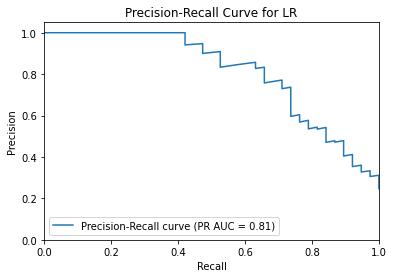

In [78]:
y_proba = model_lr.predict_proba(X_test_v1)[:, 1]

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (PR AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for LR')
plt.legend(loc="lower left")
plt.show()

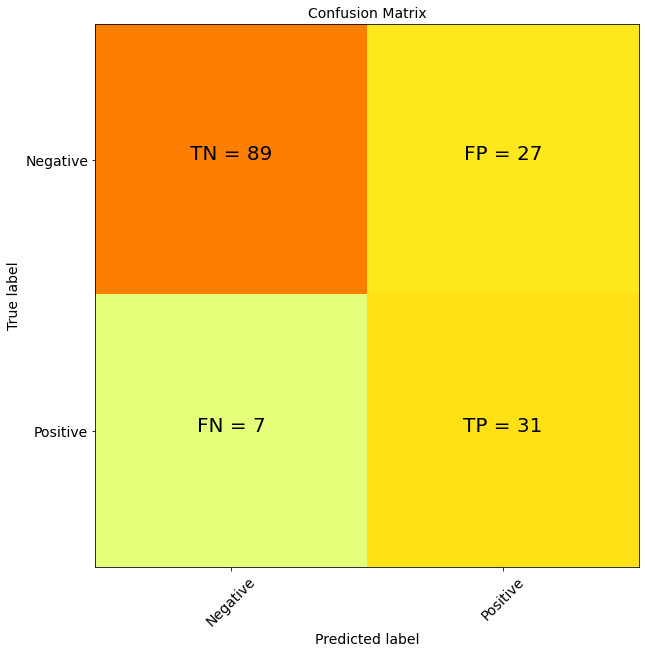

In [79]:
conf_matrix(y_test,predictions_lr)

In [80]:
# Logistic Regression + Lasso
model_lasso = LogisticRegression(penalty='l1', solver='liblinear') #Lasso

model_lasso.fit(X_train_v1, y_train)

predictions_lasso = model_lasso.predict(X_test_v1)
y_proba = model_lasso.predict_proba(X_test_v1)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_proba)

accuracy_lasso = accuracy_score(y_test, predictions_lasso)
precision_lasso = precision_score(y_test, predictions_lasso, average='binary')
recall_lasso = recall_score(y_test, predictions_lasso, average='binary')
f1_lasso = f1_score(y_test, predictions_lasso, average='binary')

print("PR AUC:", pr_auc)
print("ROC AUC:", roc_auc)
print("Accuracy LR + Lasso:", accuracy_lasso)
print("Precision LR + Lasso:", precision_lasso)
print("Recall LR + Lasso:", recall_lasso)
print("F1 Score LR + Lasso:", f1_lasso)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


PR AUC: 0.8025563981672981
ROC AUC: 0.8788566243194192
Accuracy LR + Lasso: 0.7792207792207793
Precision LR + Lasso: 0.5344827586206896
Recall LR + Lasso: 0.8157894736842105
F1 Score LR + Lasso: 0.6458333333333334


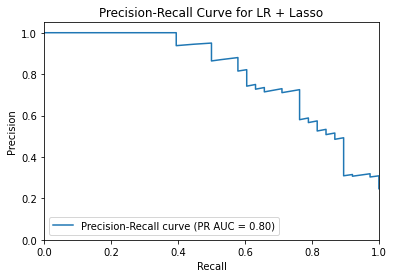

In [81]:
y_proba = model_lasso.predict_proba(X_test_v1)[:, 1]

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (PR AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for LR + Lasso')
plt.legend(loc="lower left")
plt.show()

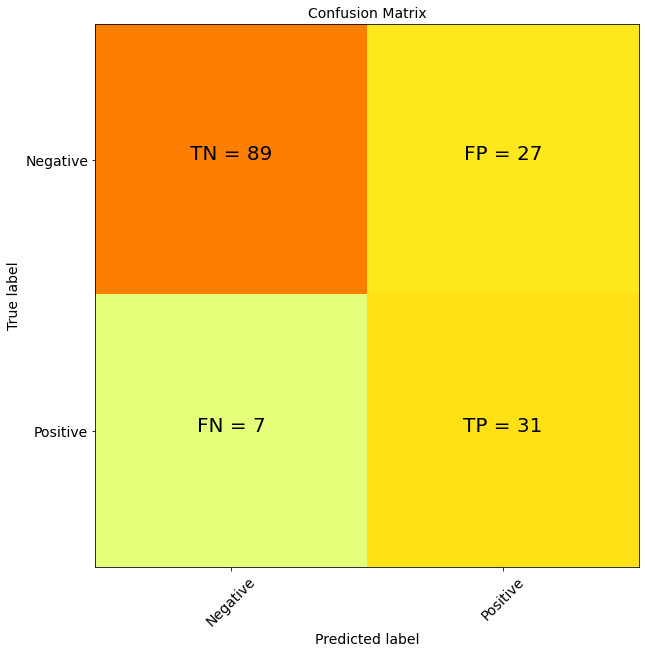

In [82]:
conf_matrix(y_test,predictions_lasso)

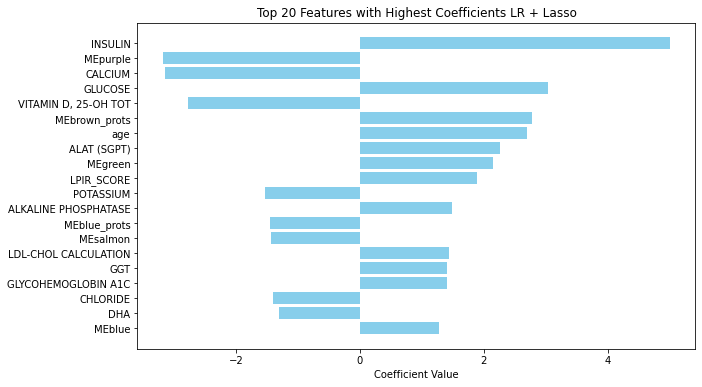

In [83]:
coefficients_lasso = model_lasso.coef_[0]
feature_names_lasso = X_train_v2.columns
coefficients_df_lasso = pd.DataFrame({'Feature': feature_names_lasso, 'Coefficient': coefficients_lasso})

# Sort DataFrame by absolute value of coefficients
coefficients_df_lasso['Abs_Coefficient'] = abs(coefficients_df_lasso['Coefficient'])
coefficients_df_lasso = coefficients_df_lasso.sort_values(by='Abs_Coefficient', ascending=False)

top_20_features = coefficients_df_lasso.head(20)

# Plot top 20 features with highest coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 20 Features with Highest Coefficients LR + Lasso')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
plt.show()

In [18]:
#Finding the best value for the regularization paramter using cross-validation
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
model_lasso_cv = LogisticRegressionCV(Cs=10, cv=10, penalty='l1', solver='liblinear', random_state=42, max_iter=10000)
model_lasso_cv.fit(X_train_v1, y_train)

# Best model's C and corresponding lambda
best_C = model_lasso_cv.C_[0]  #Best C value
best_lambda = 1 / best_C  # Convert C to lambda

print(f"Best C: {best_C}")
print(f"Best Lambda (1/C): {best_lambda}")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best C: 1291.5496650148827
Best Lambda (1/C): 0.0007742636826811277


In [19]:
best_log_lambda = -np.log10(best_lambda)
print(best_log_lambda)

3.1111111111111107


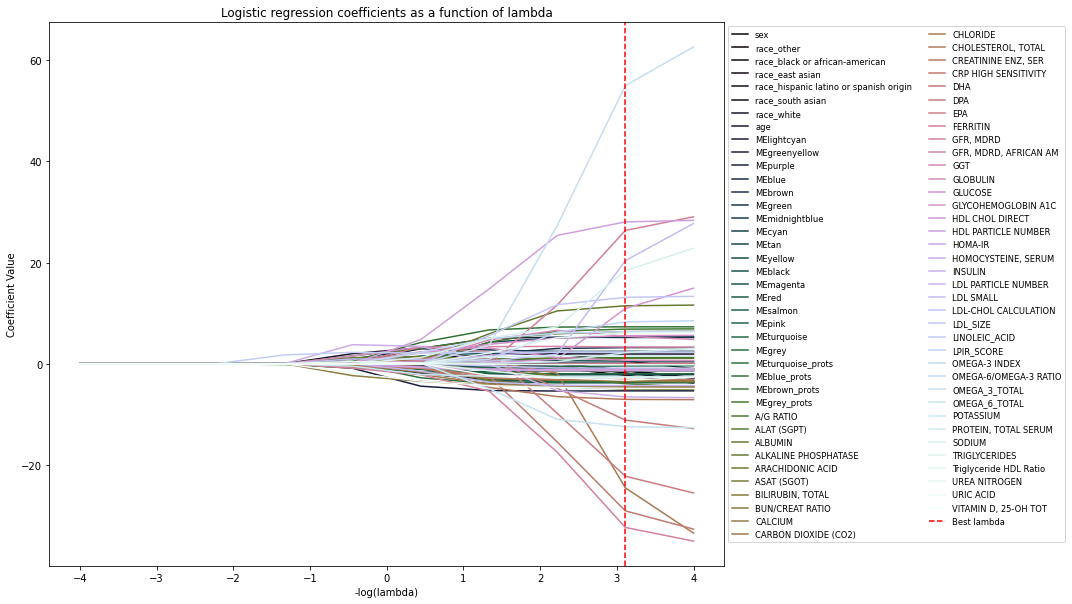

In [43]:
coefs = np.array(model_lasso_cv.coefs_paths_[1])  # Extract coefficients for each fold and C value
mean_coefs = coefs.mean(axis=0)  # Average over folds
log_lambdas = -np.log10(1/model_lasso_cv.Cs_)  # Convert Cs to log(lambda)

sns.set_palette("cubehelix", len(mean_coefs[0])) 

if mean_coefs.shape[1] == len(X_train_v2.columns) + 1:
    intercept = mean_coefs[:, 0]  # Assuming intercept is the first column
    mean_coefs = mean_coefs[:, 1:]  # Exclude intercept from feature plotting

# Plotting
plt.figure(figsize=(15, 10))
for i in range(mean_coefs.shape[1]):
    plt.plot(log_lambdas, mean_coefs[:, i], label=X_train_v2.columns[i])

plt.xlabel('-log(lambda)')
plt.ylabel('Coefficient Value')
plt.title('Logistic regression coefficients as a function of lambda')
plt.axvline(x=3.11, color='r', linestyle='--', label='Best lambda')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', ncol=2)
plt.subplots_adjust(right=0.75)
plt.show()

In [67]:
coefficients = model_lasso_cv.coef_[0]

# Map feature names to their corresponding coefficients
feature_coefficients = pd.DataFrame({'Feature': X_train_v2.columns, 'Coefficient': coefficients}).sort_values(by='Coefficient', ascending=False)


# Display the coefficients
print(feature_coefficients)

                                   Feature  Coefficient
66                           OMEGA_3_TOTAL    56.593112
55                                 HOMA-IR    28.001241
47                               GFR, MDRD    26.602995
60                    LDL-CHOL CALCULATION    18.857735
71                           TRIGLYCERIDES    17.447133
62                           LINOLEIC_ACID    12.813691
33                        ARACHIDONIC ACID    11.174032
53                         HDL CHOL DIRECT    10.131622
27                           MEbrown_prots     7.248614
29                               A/G RATIO     6.617513
64                           OMEGA-3 INDEX     6.556852
65                   OMEGA-6/OMEGA-3 RATIO     6.226713
30                             ALAT (SGPT)     6.165542
73                           UREA NITROGEN     5.975897
50                                GLOBULIN     5.461354
52                     GLYCOHEMOGLOBIN A1C     5.246357
16                                   MEtan     5

In [41]:
predictions_lasso_cv = model_lasso_cv.predict(X_test_v1)
y_proba = model_lasso_cv.predict_proba(X_test_v1)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc_cv = auc(recall, precision)
roc_auc_cv = roc_auc_score(y_test, y_proba)

accuracy_lasso_cv = accuracy_score(y_test, predictions_lasso_cv)
precision_lasso_cv = precision_score(y_test, predictions_lasso_cv, average='binary')
recall_lasso_cv = recall_score(y_test, predictions_lasso_cv, average='binary')
f1_lasso_cv = f1_score(y_test, predictions_lasso_cv, average='binary')

print("PR AUC LassoCV:", pr_auc_cv)
print("ROC AUC LassoCV:", roc_auc_cv)
print("Accuracy LR + LassoCV:", accuracy_lasso_cv)
print("Precision LR + LassoCV:", precision_lasso_cv)
print("Recall LR + LassoCV:", recall_lasso_cv)
print("F1 Score LR + LassoCV:", f1_lasso_cv)

PR AUC LassoCV: 0.7925301036437941
ROC AUC LassoCV: 0.8756805807622504
Accuracy LR + LassoCV: 0.7987012987012987
Precision LR + LassoCV: 0.5660377358490566
Recall LR + LassoCV: 0.7894736842105263
F1 Score LR + LassoCV: 0.6593406593406593


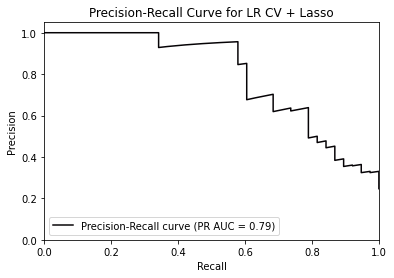

In [43]:
# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (PR AUC = %0.2f)' % pr_auc_cv)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for LR CV + Lasso')
plt.legend(loc="lower left")
plt.show()

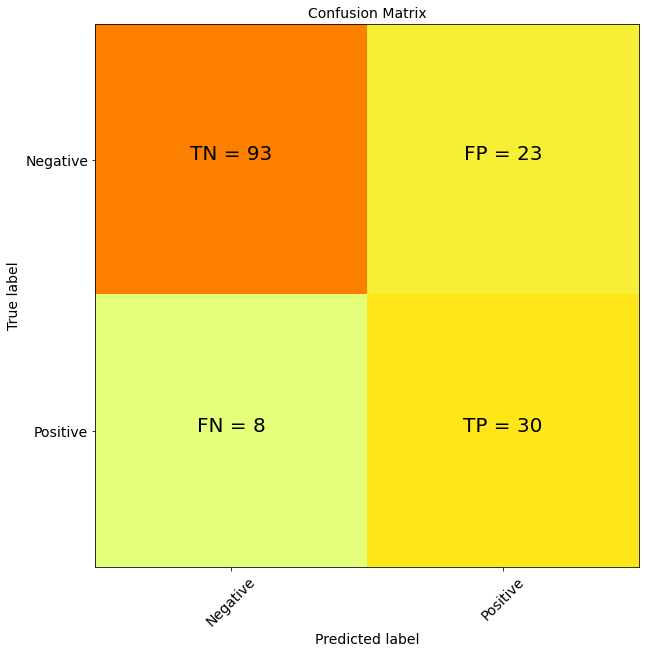

In [44]:
conf_matrix(y_test,predictions_lasso_cv)

In [84]:
# Logistic Regression + Ridge
model_ridge = LogisticRegression(penalty='l2', solver='liblinear') #Ridge

model_ridge.fit(X_train_v1, y_train)

predictions_ridge = model_ridge.predict(X_test_v1)
y_proba_ridge = model_ridge.predict_proba(X_test_v1)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_ridge)
pr_auc_ridge = auc(recall, precision)
roc_auc_ridge = roc_auc_score(y_test, y_proba_ridge)

accuracy_ridge = accuracy_score(y_test, predictions_ridge)
precision_ridge = precision_score(y_test, predictions_ridge, average='binary')
recall_ridge = recall_score(y_test, predictions_ridge, average='binary')
f1_ridge = f1_score(y_test, predictions_ridge, average='binary')

print("PR AUC Ridge:", pr_auc_ridge)
print("ROC AUC Ridge:", roc_auc_ridge)
print("Accuracy LR + Ridge:", accuracy_ridge)
print("Precision LR + Ridge:", precision_ridge)
print("Recall LR + Ridge:", recall_ridge)
print("F1 Score LR + Ridge:", f1_ridge)

PR AUC Ridge: 0.8090447827152129
ROC AUC Ridge: 0.889065335753176
Accuracy LR + Ridge: 0.7857142857142857
Precision LR + Ridge: 0.5423728813559322
Recall LR + Ridge: 0.8421052631578947
F1 Score LR + Ridge: 0.6597938144329897


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


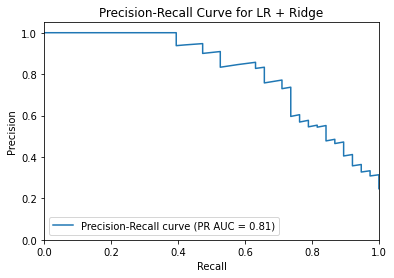

In [85]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_ridge)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (PR AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for LR + Ridge')
plt.legend(loc="lower left")
plt.show()

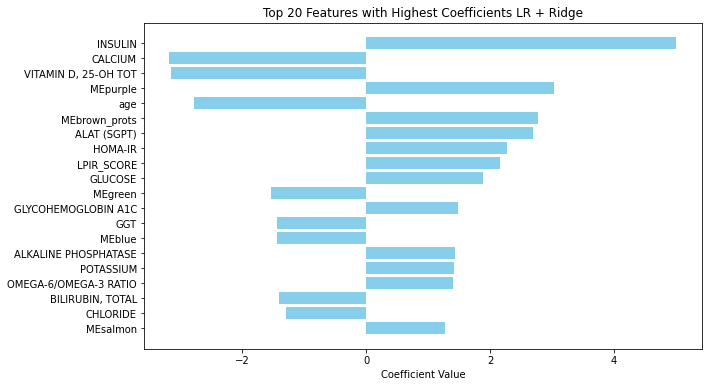

In [86]:
coefficients_ridge = model_ridge.coef_[0]
feature_names_ridge = X_train_v2.columns
coefficients_df_ridge = pd.DataFrame({'Feature': feature_names_ridge, 'Coefficient': coefficients_ridge})

# Sort DataFrame by absolute value of coefficients
coefficients_df_ridge['Abs_Coefficient'] = abs(coefficients_df_ridge['Coefficient'])
coefficients_df_ridge = coefficients_df_ridge.sort_values(by='Abs_Coefficient', ascending=False)

top_20_features_ridge = coefficients_df_ridge.head(20)

# Plot top 20 features with highest coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_20_features_ridge['Feature'], top_20_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 20 Features with Highest Coefficients LR + Ridge')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
plt.show()

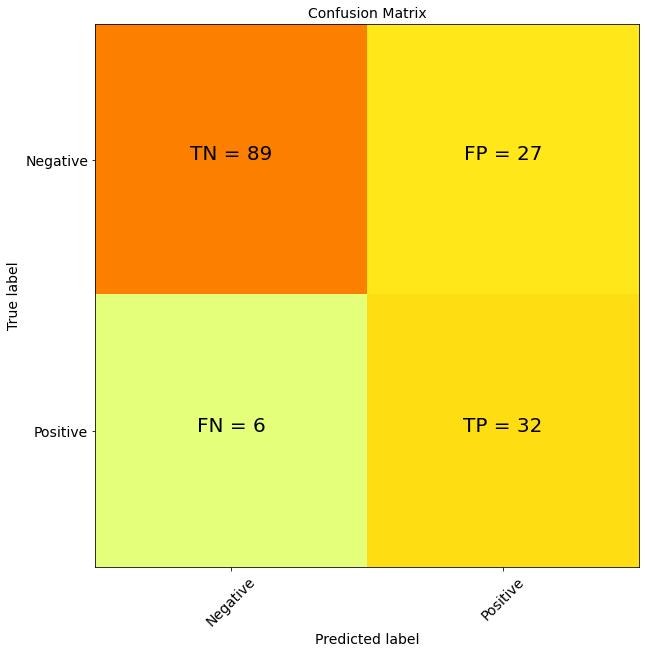

In [87]:
conf_matrix(y_test,predictions_ridge)

In [88]:
model_xgb = xgb.XGBClassifier()

model_xgb.fit(X_train_v1, y_train)

y_pred_xgb = model_xgb.predict(X_test_v1)
y_proba_xgb = model_xgb.predict_proba(X_test_v1)[:, 1]

In [89]:
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_proba_xgb)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='binary')
recall_xgb = recall_score(y_test, y_pred_xgb, average='binary')
f1_xgb = f1_score(y_test, y_pred_xgb, average='binary')

print("PR AUC:", pr_auc)
print("ROC AUC:", roc_auc)
print("Accuracy XGB:", accuracy_xgb)
print("Precision XGB:", precision_xgb)
print("Recall XGB:", recall_xgb)
print("F1 Score XGB:", f1_xgb)

PR AUC: 0.8241714305543074
ROC AUC: 0.9235480943738656
Accuracy XGB: 0.8311688311688312
Precision XGB: 0.6363636363636364
Recall XGB: 0.7368421052631579
F1 Score XGB: 0.6829268292682927


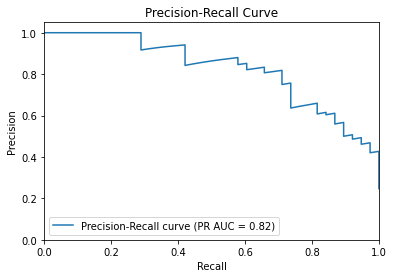

In [90]:
y_proba = model_xgb.predict_proba(X_test_v1)[:, 1]

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (PR AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

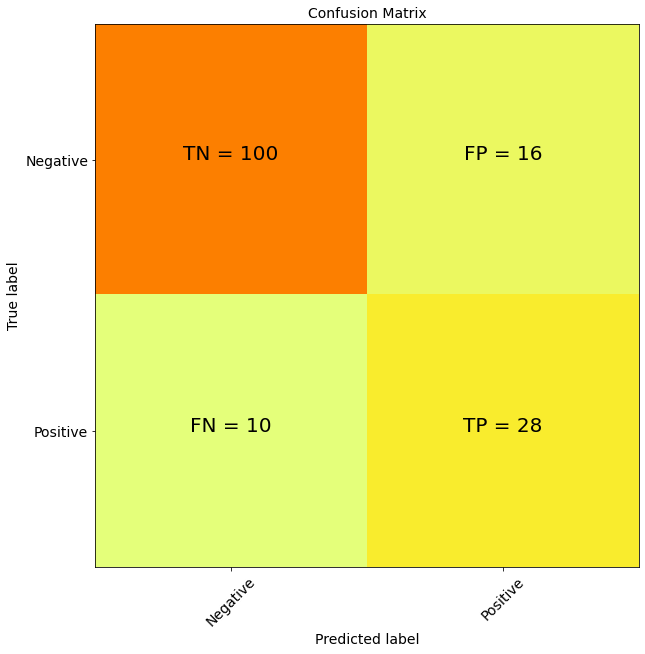

In [91]:
conf_matrix(y_test,y_pred_xgb)

In [92]:
columns_sel = X_train_v2.columns
X_test_v3 = X_test_v2[columns_sel]

In [93]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_v3)

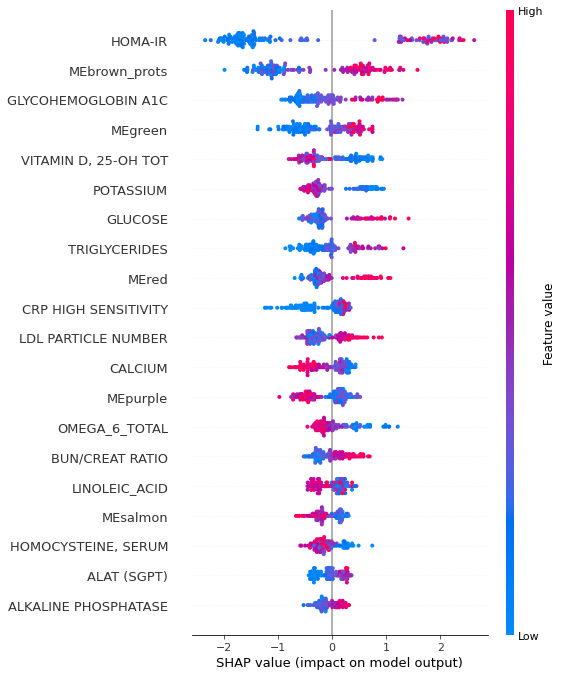

In [94]:
shap.summary_plot(shap_values, X_test_v3, max_display=20, show = False)
plt.show()

In [94]:
X_test_v4 = X_test[columns_sel]

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_v4)

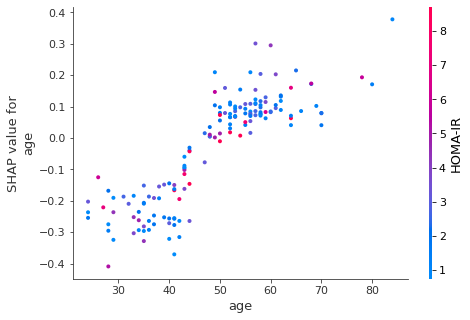

In [101]:
shap.dependence_plot("age", shap_values, X_test_v4, interaction_index="HOMA-IR")

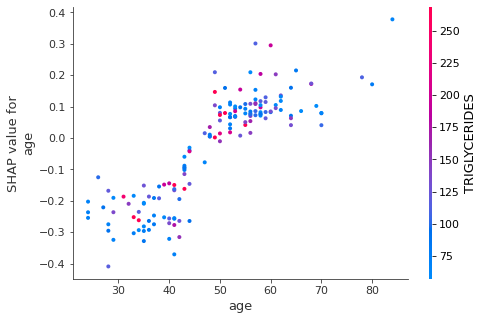

In [ ]:
shap.dependence_plot("age", shap_values, X_test_v4, interaction_index="TRIGLYCERIDES")

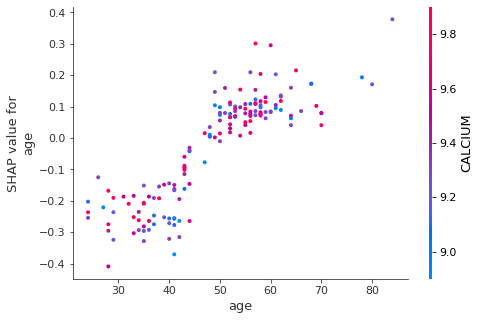

In [92]:
shap.dependence_plot("age", shap_values, X_test_v4, interaction_index="CALCIUM")

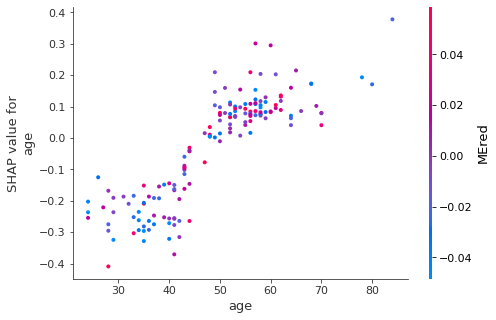

In [100]:
shap.dependence_plot("age", shap_values, X_test_v4, interaction_index="MEred")

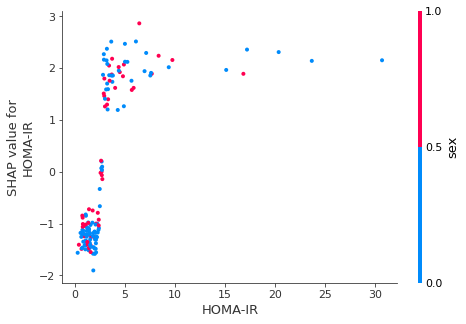

In [111]:
shap.dependence_plot("HOMA-IR", shap_values, X_test_v4, interaction_index="sex")

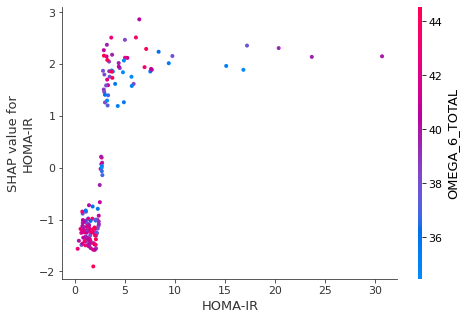

In [113]:
shap.dependence_plot("HOMA-IR", shap_values, X_test_v4)

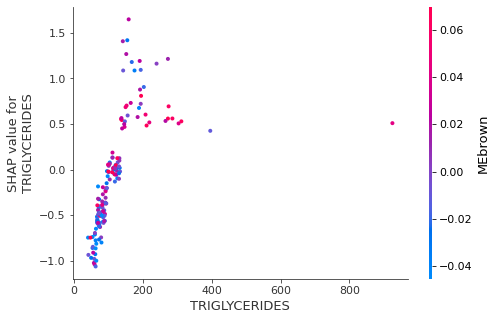

In [114]:
shap.dependence_plot("TRIGLYCERIDES", shap_values, X_test_v4)

In [59]:
# hyperparameter tuning and k-fold cross-validation

xgb_hyper = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
}

#Straitifed K-fold preserves the percentage of samples for each class
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb_hyper, param_grid=param_grid, scoring='accuracy', cv=kfold)

grid_result = grid_search.fit(X_train_v1, y_train)

print("Best Parameters: ", grid_result.best_params_)

xgb_best_model = grid_result.best_estimator_

xgb_pred_best_model = xgb_best_model.predict(X_test_v1)

accuracy_xgb_best_model = accuracy_score(y_test, xgb_pred_best_model)
precision_xgb_best_model = precision_score(y_test, xgb_pred_best_model, average='binary')
recall_xgb_best_model = recall_score(y_test, xgb_pred_best_model, average='binary')
f1_xgb_best_model = f1_score(y_test, xgb_pred_best_model, average='binary')

print("Accuracy XGB Best Model:", accuracy_xgb_best_model)
print("Precision XGB Best Model:", precision_xgb_best_model)
print("Recall XGB Best Model:", recall_xgb_best_model)
print("F1 Score XGB Best Model:", f1_xgb_best_model)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Accuracy XGB Best Model: 0.8636363636363636
Precision XGB Best Model: 0.6976744186046512
Recall XGB Best Model: 0.7894736842105263
F1 Score XGB Best Model: 0.7407407407407407


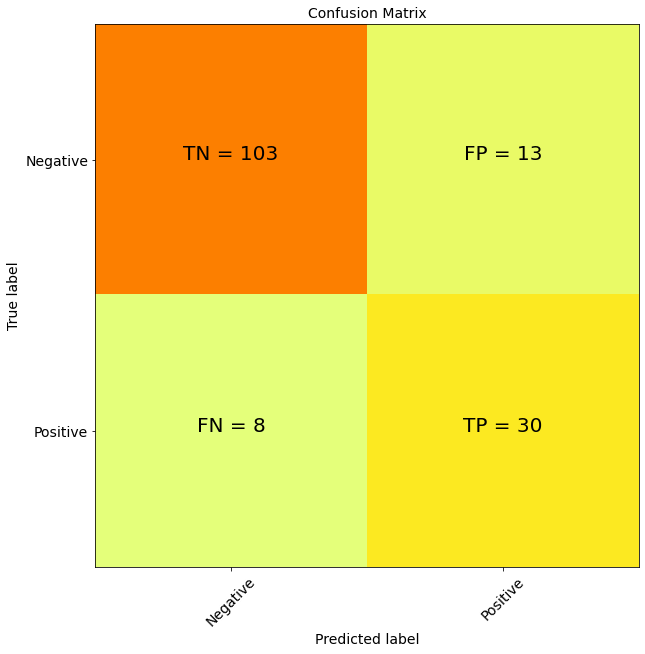

In [61]:
conf_matrix(y_test,xgb_pred_best_model)

In [56]:
#Manually adjust threshold
def adjust_threshold(X_test, threshold, model):
    probs = model.predict_proba(X_test)[:, 1] 
    y_pred = (probs >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    
new_preds = adjust_threshold(X_test= X_test_v1, threshold=0.4, model=model_lasso_cv) 

Precision: 0.5
Recall: 0.7894736842105263
F1 Score: 0.6122448979591837
